<center> <img src = "https://miro.medium.com/max/1400/1*f7m92eei7PE8gFyaCQnXMw.jpeg"></center><br>

# <center>👨‍💻 | Loan Default Prediction 💰</center><br><br>
# Introduction <br>
Loans are an essential part of our economy.People borrow money from financial institutions all the time, either for starting a business, emergency expenses, vehicle financing, vacation costs, or education costs. <br><br>
However, when lending money to someone, there is always the risk that that person may not be able to pay you back. When it comes to financial institutions, such as banks, that borrow large amounts of money to many different people for many different reasons, the risk of losses from defaults gets exponentially higher.<br><br>
For this reason, it is extremely important that financial institutions avoid loans to people that are highly likely to default, and they usually invest a lot of time and resources in background checks on people to avoid having losses. In this notebook, I'll develop a machine learning model that will be able to predict how likely a client is to default based on whether or not he's employed, his bank balance, and his annual salary. 

<h1 style = "border-bottom: 3px solid black; padding: 8px"><b>1 | Importing Libraries</b></h1>

In [57]:
# Installing PyCaret
# !pip install --ignore-installed pycaret --user

In [47]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)


<h1 style = "border-bottom: 3px solid black; padding: 8px"><b>2 | Exploratory Data Analysis</b></h1>

In [46]:
# Loading data and visualizing dataframe
df = pd.read_csv(r'C:\Users\admin12\Desktop\Internship Project\Loan Default Prediction.csv')
df

,Index,Employed,Bank Balance,Annual Salary,Defaulted?
0,1,1,8754.36,532339.56,0
1,2,0,9806.16,145273.56,0
2,3,1,12882.60,381205.68,0
3,4,1,6351.00,428453.88,0
4,5,1,9427.92,461562.00,0
...,...,...,...,...,...
9995,9996,1,8538.72,635908.56,0
9996,9997,1,9095.52,235928.64,0
9997,9998,1,10144.92,703633.92,0
9998,9999,1,18828.12,440029.32,0


In [48]:
df.shape

(10000, 5)

<h3 style = "border-bottom: 3px solid black; padding: 8px"><b>About the Dataset</b></h3>

To develop this loan default predictor, we have a dataset with a total of **10,000** clients and **four different attributes**: <br><br>
> - **Employed**: 1 for employed and 0 for unemployed;<br><br>
> - **Bank Balance**: The amount of money that client had available in their account at the moment the data was obtained;<br><br>
> - **Annual Salary**: The annual salary of each client;<br><br>
> - **Defaulted?**: This is our **target variable** and it's filled of 0 for each client who **didn't default** and 1 for each client who **defaulted their loans**.<br><br>

Let's use some **EDA** to see how balanced the target variable is and how it interacts with other attributes!

In [49]:
# Checking null values 
df.isnull().sum()

Index            0
Employed         0
Bank Balance     0
Annual Salary    0
Defaulted?       0
dtype: int64

In [50]:
# Renaming target variable
df.rename({'Defaulted?':'Defaulted'}, axis = 1, inplace = True)
df

,Index,Employed,Bank Balance,Annual Salary,Defaulted
0,1,1,8754.36,532339.56,0
1,2,0,9806.16,145273.56,0
2,3,1,12882.60,381205.68,0
3,4,1,6351.00,428453.88,0
4,5,1,9427.92,461562.00,0
...,...,...,...,...,...
9995,9996,1,8538.72,635908.56,0
9996,9997,1,9095.52,235928.64,0
9997,9998,1,10144.92,703633.92,0
9998,9999,1,18828.12,440029.32,0


In [43]:
df.describe()

,Index,Employed,Bank Balance,Annual Salary,Defaulted
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,0.705600,10024.498524,402203.782224,0.033300
std,2886.89568,0.455795,5804.579486,160039.674988,0.179428
min,1.00000,0.000000,0.000000,9263.640000,0.000000
25%,2500.75000,0.000000,5780.790000,256085.520000,0.000000
50%,5000.50000,1.000000,9883.620000,414631.740000,0.000000
75%,7500.25000,1.000000,13995.660000,525692.760000,0.000000
max,10000.00000,1.000000,31851.840000,882650.760000,1.000000


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          10000 non-null  int64  
 1   Employed       10000 non-null  int64  
 2   Bank Balance   10000 non-null  float64
 3   Annual Salary  10000 non-null  float64
 4   Defaulted      10000 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 390.8 KB


In [52]:
# Checking class balance
fig = px.pie(df, values = df['Defaulted'].value_counts(), names = ['Did not default','Defaulted'], title = 'Distribution of Clients Who Have Defaulted')
fig.update_traces(rotation=90, pull = [0.2,0.06,0.06,0.06,0.06], textinfo = "percent+label")
fig.show()

It's possible to see that most clients didn't default their loans, which means we have a **class imbalance** issue with our data.<br><br>
Later on I'll use different methods to deal with this imbalance while building our predictor model with AutoML.

Let's separate our clients among those who are employed and those who are unemployed and see how the target variable is distributed among each separate group.

In [53]:
# Separating df into two different groups: Employed clients and unemployed clients
employed = df.query("Employed == 1")
unemployed = df.query("Employed == 0")

In [54]:
# Checking class balance among those who are employed
fig = px.pie(employed, values = employed['Defaulted'].value_counts(), names = ['Did not default','Defaulted'], title = 'Distribution of Clients Who Are Employed and Defaulted')
fig.update_traces(rotation=90, pull = [0.2,0.06,0.06,0.06,0.06], textinfo = "percent+label")
fig.show()

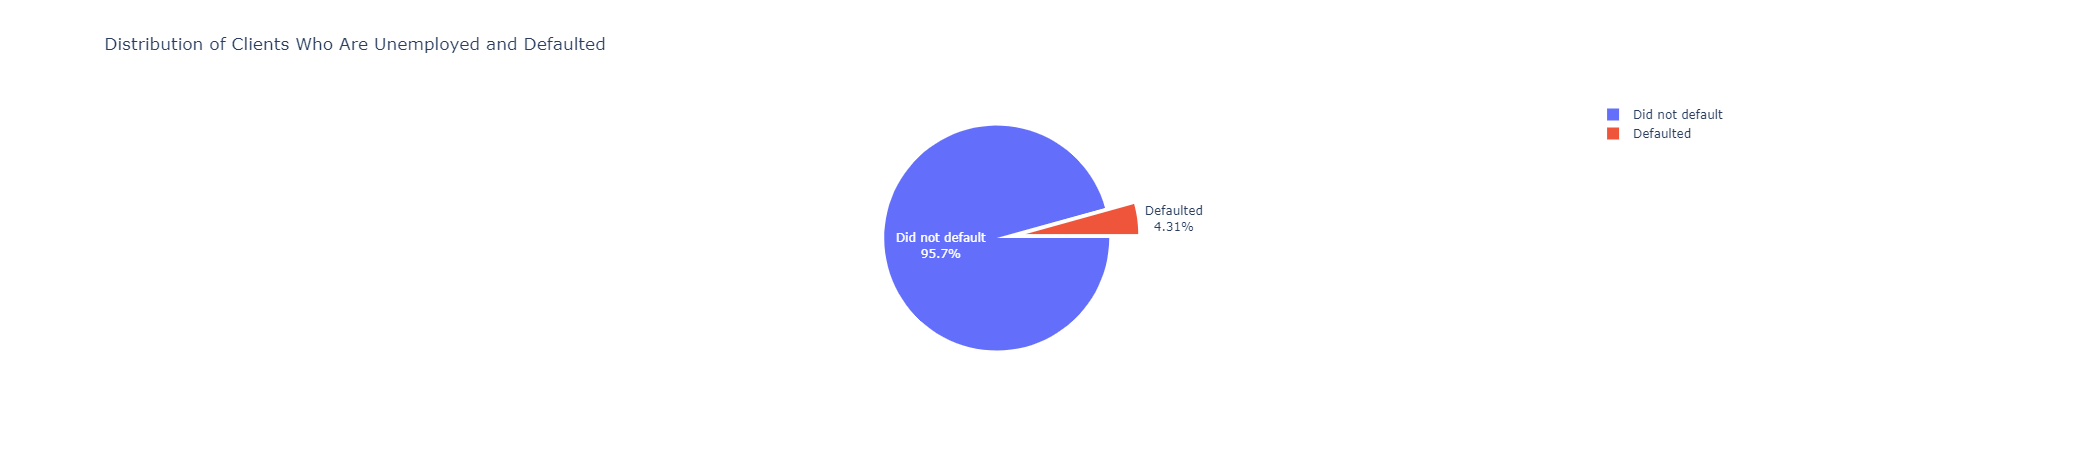

In [65]:
# Checking class balance among those who are unemployed
fig = px.pie(unemployed, values = unemployed['Defaulted'].value_counts(), names = ['Did not default','Defaulted'], title = 'Distribution of Clients Who Are Unemployed and Defaulted')
fig.update_traces(rotation=90, pull = [0.2,0.06,0.06,0.06,0.06], textinfo = "percent+label")
fig.show()

It doesn't come off as a surprise that the proportion of those who've defaulted is bigger among unmeployed clients than employed clients.

Let's now see our the 'Defaulted' class is distributed according to bank balance and annual salary.

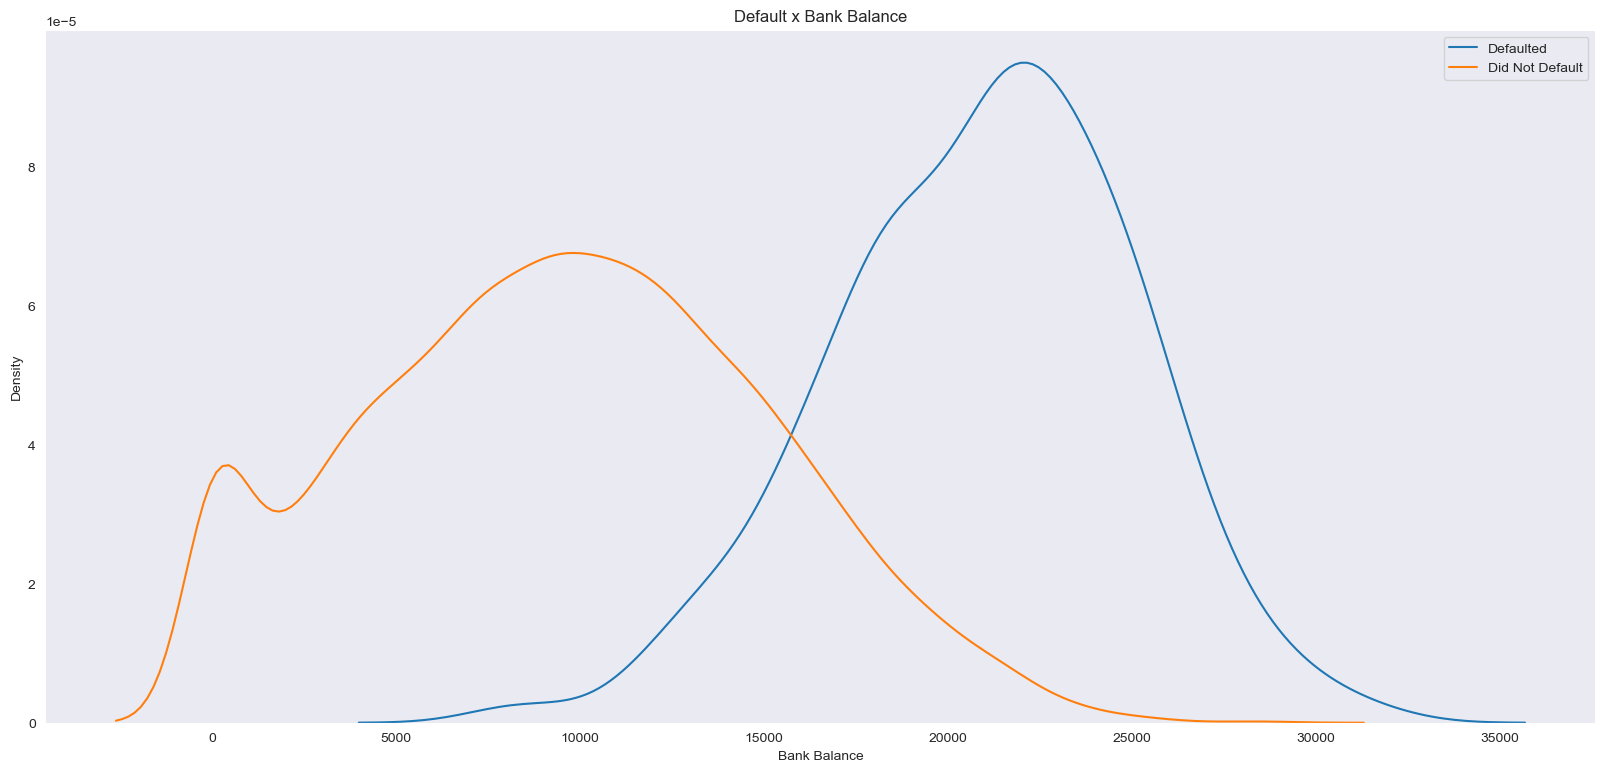

In [12]:
# Default distribution according to bank balance values
fig = plt.figure(figsize = (20, 9))
sns.set_style("dark")
sns.kdeplot(df[df['Defaulted']==1]['Bank Balance'])
sns.kdeplot(df[df['Defaulted']==0]['Bank Balance'])
plt.title('Default x Bank Balance')
plt.legend(labels=['Defaulted', 'Did Not Default'])
plt.show()

On average, we can see that clients who defaulted their loans have a higher bank balance than those who didn't.

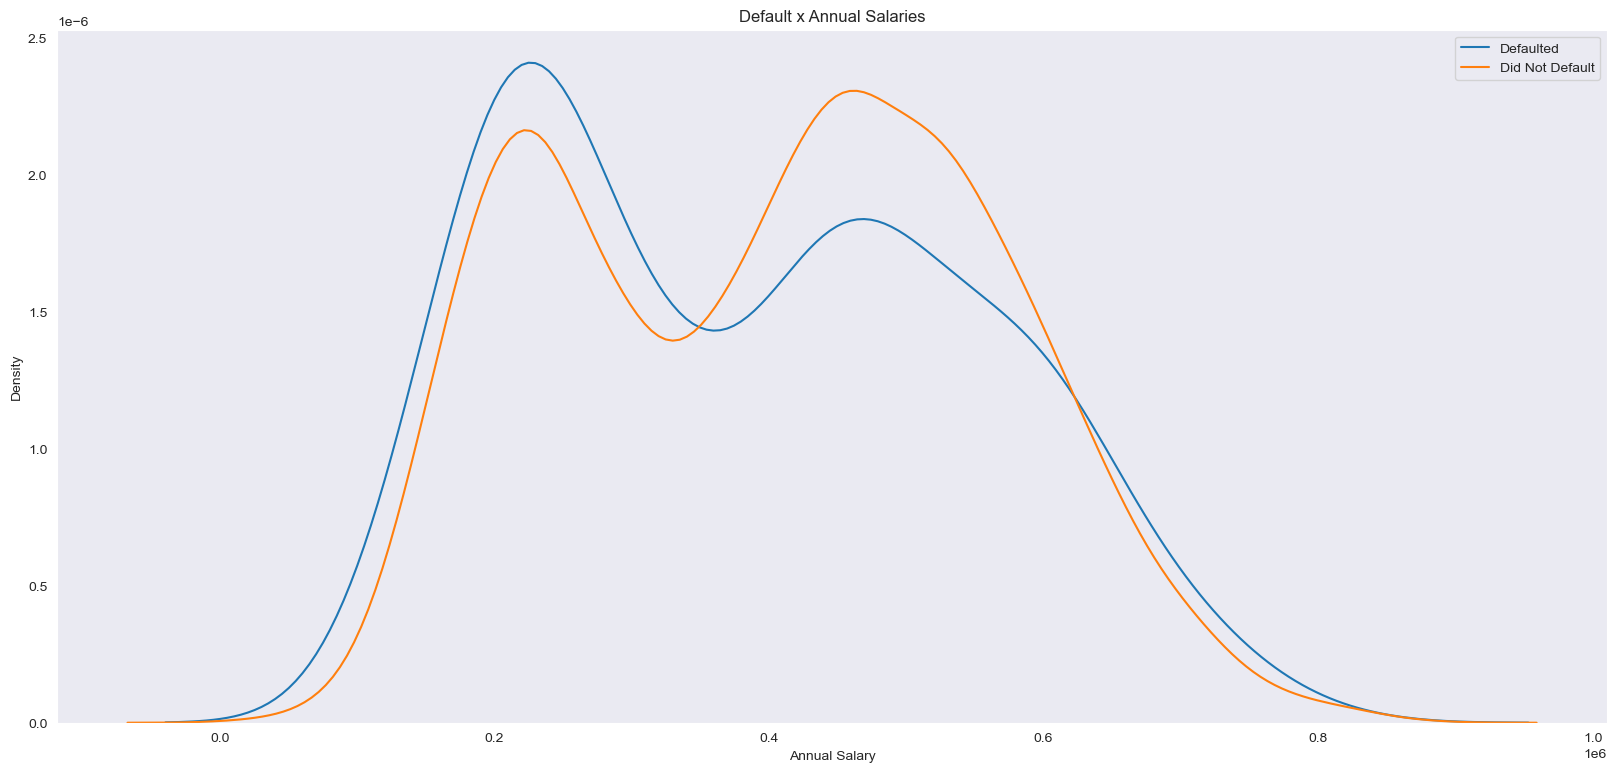

In [13]:
# Default distribution according to annual salaries
fig = plt.figure(figsize = (20, 9))
sns.set_style("dark")
sns.kdeplot(df[df['Defaulted']==1]['Annual Salary'])
sns.kdeplot(df[df['Defaulted']==0]['Annual Salary'])
plt.title('Default x Annual Salaries')
plt.legend(labels=['Defaulted', 'Did Not Default'])
plt.show()

On average, clients who defaulted have lower annual income than those who didn't.

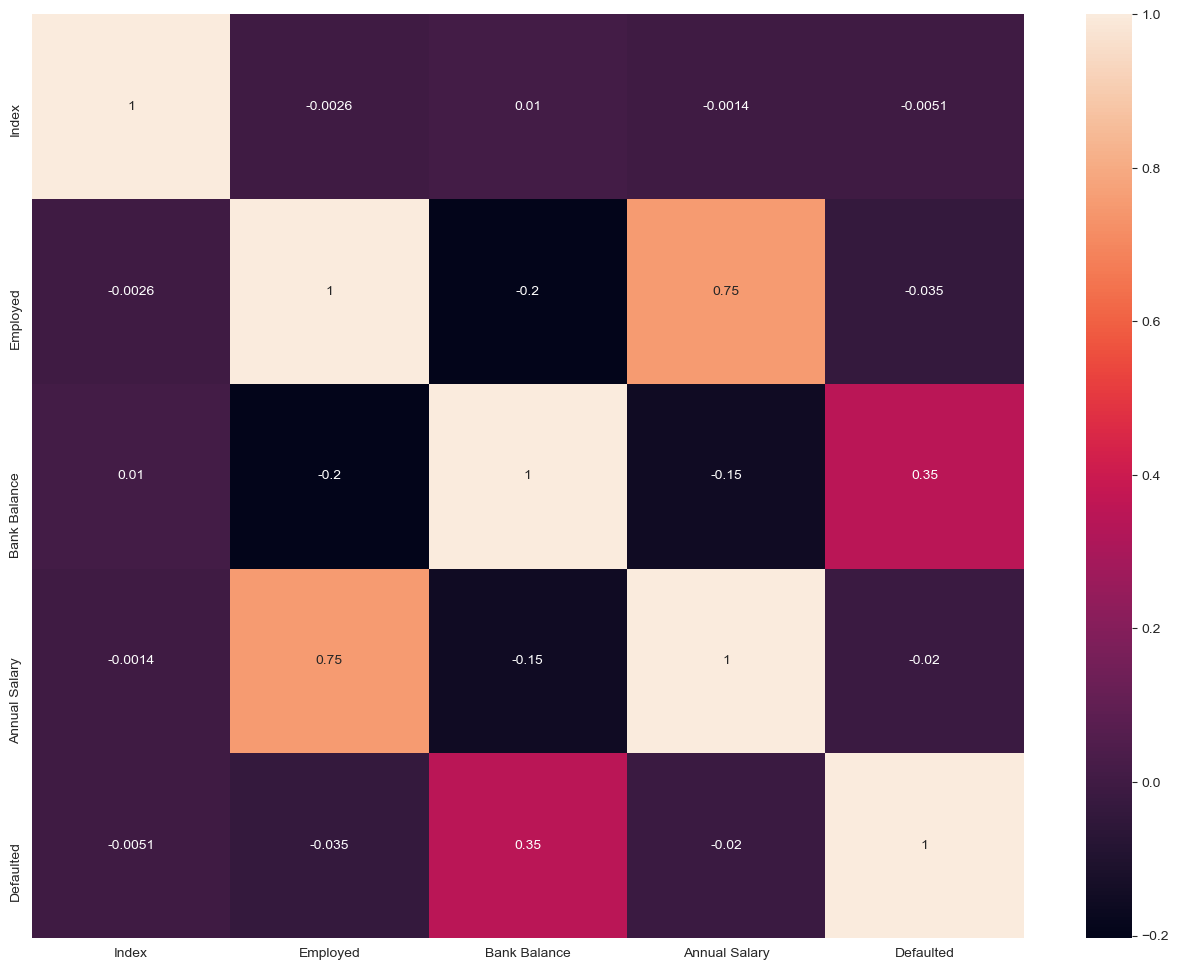

In [14]:
# Checking correlations
corr = df.corr()
plt.figure(figsize = (16, 12))
g = sns.heatmap(df.corr(), annot = True)

The strongest correlation we have is among **Annual Salary** and **Employed**, but we don't really have any strong correlation between the target variable and any other attribute. We only have a 35% correlation among **Defaulted** and **Bank Balance**, but that isn't a strong correlation at all.

In [15]:
test = df.tail(2000) # 20% of dataset will be used for testing
test

,Index,Employed,Bank Balance,Annual Salary,Defaulted
8000,8001,1,3649.80,286403.28,0
8001,8002,1,4243.56,488241.12,0
8002,8003,1,15233.04,468121.80,0
8003,8004,0,4770.48,272530.44,0
8004,8005,1,7286.04,594569.64,0
...,...,...,...,...,...
9995,9996,1,8538.72,635908.56,0
9996,9997,1,9095.52,235928.64,0
9997,9998,1,10144.92,703633.92,0
9998,9999,1,18828.12,440029.32,0


In [16]:
# Removing testing data from dataframe and setting up 80% of data left for training and validation
train = df.drop(test.index)
train

,Index,Employed,Bank Balance,Annual Salary,Defaulted
0,1,1,8754.36,532339.56,0
1,2,0,9806.16,145273.56,0
2,3,1,12882.60,381205.68,0
3,4,1,6351.00,428453.88,0
4,5,1,9427.92,461562.00,0
...,...,...,...,...,...
7995,7996,1,8095.20,807347.40,0
7996,7997,1,13173.12,506747.64,0
7997,7998,1,7116.72,573451.20,0
7998,7999,1,14005.20,431426.28,0


Let's create three different models with the top 3 best ranked algorithms, tune them, blend them and see how this affects performance!

No improvement made. Let's tune each one of our models.

All three models have the same recall score of 94.29%.<br><br>
Tune_qda has the best Accuracy score, 82.68%.

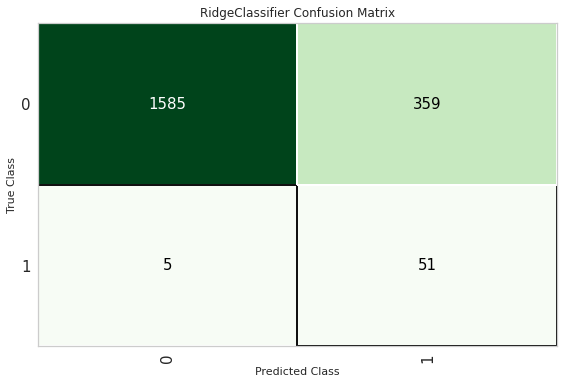

In [89]:
plot_model(tuned_ridge, plot = 'confusion_matrix')

As we can see, all three models had the same value for false negatives, which was 5 defaulters predicted as non-defaulters.<br><br>
Tuned_qda had the lowest number of false positives, 357.

**Bank Balance** seems to be the most important feature to predict default, which happens to be the feature with the highest positive correlation with the target variable

Finally, let's use our model on the hold-out sample to see how well it performs

We've achieved a recall score og 91.07% in our hold-out sample.

Let's now see how well our model performs with unseen data using the test set that we've created before containing the last 20% of data from the original dataset

In [38]:
test # testing set

,Index,Employed,Bank Balance,Annual Salary,Defaulted
8000,8001,1,3649.80,286403.28,0
8001,8002,1,4243.56,488241.12,0
8002,8003,1,15233.04,468121.80,0
8003,8004,0,4770.48,272530.44,0
8004,8005,1,7286.04,594569.64,0
...,...,...,...,...,...
9995,9996,1,8538.72,635908.56,0
9996,9997,1,9095.52,235928.64,0
9997,9998,1,10144.92,703633.92,0
9998,9999,1,18828.12,440029.32,0


#### **Recall Score on Testing Set** ==> 91.04%

Let's print a confusion matrix

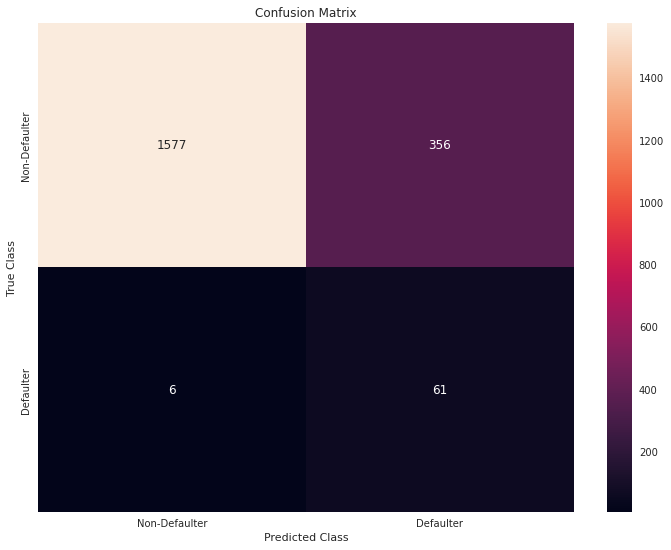

In [106]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(12,9))
ax = plt.subplot()
sns.heatmap(cm,annot = True, fmt ='g', ax = ax)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Non-Defaulter','Defaulter'])
ax.yaxis.set_ticklabels(['Non-Defaulter','Defaulter'])
plt.show()

We've had only 6 false negatives in a dataset with 67 defaulters in total, where 61 of them were correctly predicted as defaulters.

<h1 style = "border-bottom: 3px solid black; padding: 8px"><b>4 | Conclusion</b></h1>

Considering that labeling a defaulter as a non-defaulter represents a high chance of financial loss to the institution, the goal of this model was to have the highest recall possible and correctly predict the highest amount of defaulters as possible.<br><br>
